            filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.05

((6693, 58), (3297, 58), (6693,), (3297,))

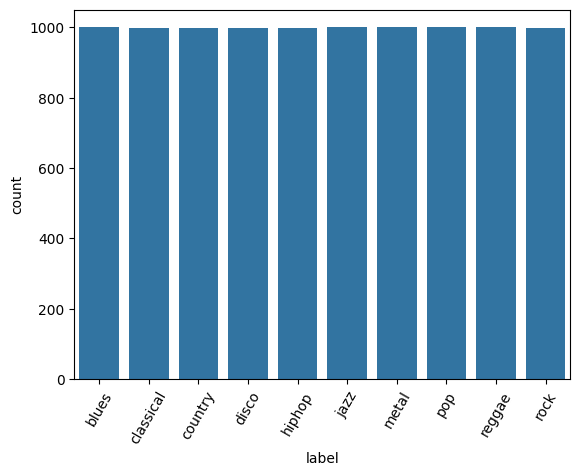

In [86]:
# %%
# imoprt libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import librosa # main package for working with Audio Data
import librosa.display
import tensorflow as tf
import IPython
import IPython.display as ipd # to play the Audio Files

from tensorflow import keras
from keras.models import Sequential
from keras import models, layers, regularizers
from glob import glob # allows us to list all files to a directory
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier  # Import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
encoder = LabelEncoder()
scaler = StandardScaler()


# %%
# Read the CSV file
df = pd.read_csv("content/features_3_sec.csv")

# Display the first few rows of the DataFrame
print(df.head())


# %%
df.head()

# %%
df.shape # see the shape of df

# %%
df.info() # infos about the samples, features and datatypes

# %%
df.isnull().sum() # checking for missing values

# %%
sns.countplot(x=df.label) # plot the categories
plt.xticks(rotation=60);

# %%
df = df.drop(labels='filename',axis=1)
df.head()

# %%
data = df.iloc[:, :-1] # get the other columns
data

# %%
labels = df.iloc[:, -1] # get labels column
labels.to_frame()

# %%
x = np.array(data, dtype = float)
x = scaler.fit_transform(data)
y = encoder.fit_transform(labels)
x.shape, y.shape

# %%
# split data to train and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [88]:
# Reshape the input data for LSTM; LSTM expects 3D input: [samples, time steps, features]
# Assuming each sample is a sequence of 1 time step with multiple features
x_train_lstm = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test_lstm = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# Define the LSTM model
lstm_model = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])),
    keras.layers.LSTM(32, return_sequences=False),  # return_sequences=False for the last LSTM layer
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')  # Assuming you have 10 classes
])

# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
print(lstm_model.summary())

# Define early stopping callback for LSTM model
early_stopping_lstm = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Fit the LSTM model
history_lstm = lstm_model.fit(x_train_lstm, y_train,
                              validation_data=(x_test_lstm, y_test),
                              epochs=100,
                              batch_size=128,
                              callbacks=[early_stopping_lstm])

# Evaluate the LSTM model
loss_lstm, accuracy_lstm = lstm_model.evaluate(x_test_lstm, y_test, batch_size=128)

print(f"LSTM Test Loss: {loss_lstm}")
print(f"LSTM Test Accuracy: {accuracy_lstm}")


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 1, 64)          │        31,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,666 (182.29 KB)

 Trainable params: 46,666 (182.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2530 - loss: 2.2610 - val_accuracy: 0.3342 - val_loss: 1.9406
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3602 - loss: 1.8028 - val_accuracy: 0.4180 - val_loss: 1.5205
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4489 - loss: 1.4866 - val_accuracy: 0.5475 - val_loss: 1.2639
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5699 - loss: 1.2366 - val_accuracy: 0.6212 - val_loss: 1.0952
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6220 - loss: 1.0895 - val_accuracy: 0.6551 - val_loss: 0.9982
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6449 - loss: 1.0067 - val_accuracy: 0.6830 - val_loss: 0.9220
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6889 - loss: 0.9171 - val_accuracy: 0.7067 - val_loss: 0.8677
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7116 - loss: 0.8350 - val_accuracy: 0.727

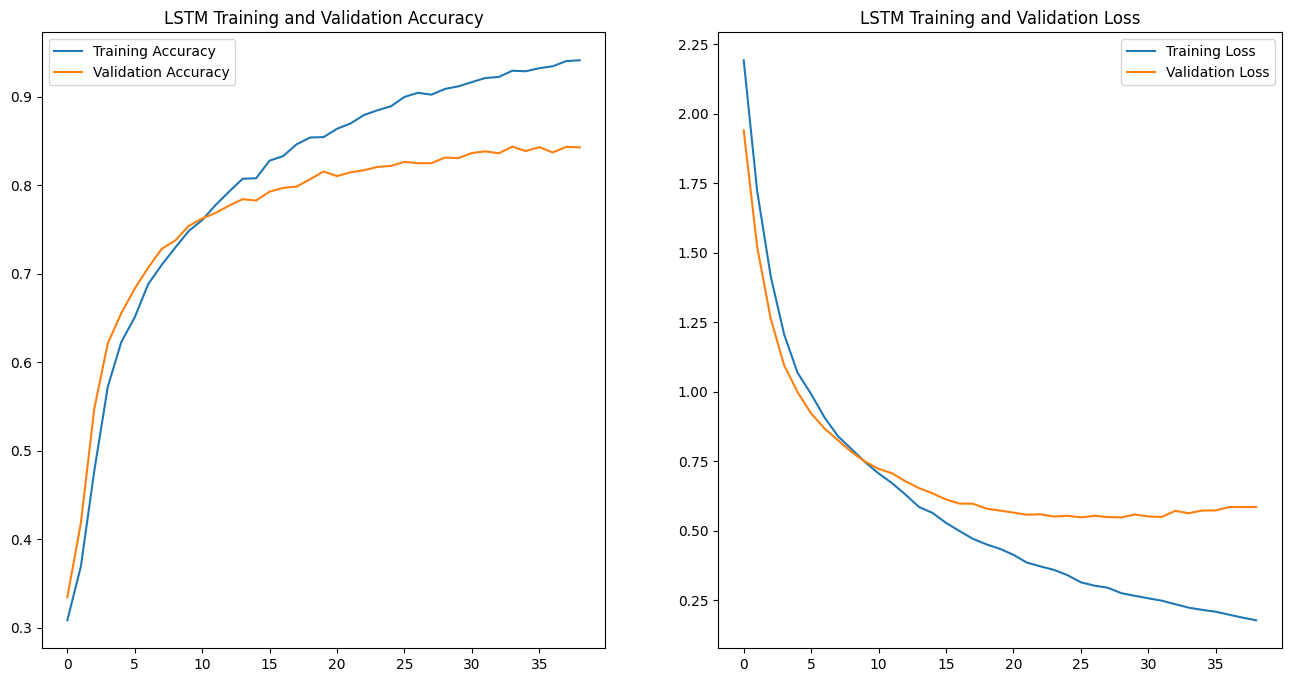

In [89]:
# Plotting accuracy and loss
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()

plt.show()
